# 13d: Fisher z-Transform Confidence Intervals for All Correlations

**Goal**: Compute 95% confidence intervals for all correlations using Fisher z-transformation.

**Method**: scipy.stats.pearsonr with confidence_interval() which uses Fisher transformation:
- F(r) = arctanh(r)
- Standard error = 1/sqrt(n-3)
- Transform back with tanh()

In [1]:
# === CONFIGURATION ===
PROJECT_ROOT = "/home/jason/v2/mk5-tailwind"
CI_LEVEL = 0.95

# === Setup imports ===
import sys
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from pathlib import Path

from forge.analysis.utils import viz
from forge.analysis.utils.hand_features import REGRESSION_FEATURES

viz.setup_notebook_style()
print(f"CI level: {CI_LEVEL*100:.0f}%")
print("Ready")

CI level: 95%
Ready


## 1. Load Unified Feature Data

In [2]:
# Load unified features (from 12b)
data_path = Path(PROJECT_ROOT) / "forge/analysis/results/tables/12b_unified_features.csv"
df = pd.read_csv(data_path)

print(f"Loaded {len(df)} samples")
print(f"Features available: {list(df.columns)}")

Loaded 200 samples
Features available: ['base_seed', 'decl_id', 'trump_suit', 'V_mean', 'V_std', 'V_spread', 'V_min', 'V_max', 'n_doubles', 'trump_count', 'max_suit_length', 'n_6_high', 'n_5_high', 'n_4_high', 'count_points', 'n_count_dominoes', 'total_pips', 'has_trump_double', 'n_voids', 'n_singletons']


## 2. Define All Correlations to Compute

In [3]:
# Define correlations of interest
correlations_to_compute = [
    # Risk-return relationships
    ('V_mean', 'V_std', 'E[V] vs σ(V)'),
    ('V_mean', 'V_spread', 'E[V] vs V_spread'),
    
    # Hand features vs E[V]
    ('n_doubles', 'V_mean', 'n_doubles vs E[V]'),
    ('trump_count', 'V_mean', 'trump_count vs E[V]'),
    ('count_points', 'V_mean', 'count_points vs E[V]'),
    ('n_6_high', 'V_mean', 'n_6_high vs E[V]'),
    ('total_pips', 'V_mean', 'total_pips vs E[V]'),
    ('has_trump_double', 'V_mean', 'has_trump_double vs E[V]'),
    ('n_voids', 'V_mean', 'n_voids vs E[V]'),
    ('n_singletons', 'V_mean', 'n_singletons vs E[V]'),
    ('n_5_high', 'V_mean', 'n_5_high vs E[V]'),
    ('max_suit_length', 'V_mean', 'max_suit_length vs E[V]'),
    
    # Hand features vs σ(V)
    ('n_6_high', 'V_std', 'n_6_high vs σ(V)'),
    ('total_pips', 'V_std', 'total_pips vs σ(V)'),
    ('n_doubles', 'V_std', 'n_doubles vs σ(V)'),
    ('trump_count', 'V_std', 'trump_count vs σ(V)'),
]

print(f"Will compute {len(correlations_to_compute)} correlations with Fisher CIs")

Will compute 16 correlations with Fisher CIs


## 3. Compute Fisher z-Transform Confidence Intervals

In [4]:
def interpret_r(r_val):
    """Cohen's conventions for correlation effect size."""
    abs_r = abs(r_val)
    if abs_r < 0.1:
        return "negligible"
    elif abs_r < 0.3:
        return "small"
    elif abs_r < 0.5:
        return "medium"
    else:
        return "large"

results = []

for var1, var2, label in correlations_to_compute:
    x = df[var1].values
    y = df[var2].values
    
    # Compute Pearson correlation with scipy (uses Fisher z internally)
    result = stats.pearsonr(x, y)
    r = result.statistic
    p = result.pvalue
    ci = result.confidence_interval(confidence_level=CI_LEVEL)
    
    # Check if significant (CI excludes zero)
    significant = (ci.low > 0) or (ci.high < 0)
    
    results.append({
        'comparison': label,
        'r': r,
        'p_value': p,
        'ci_low': ci.low,
        'ci_high': ci.high,
        'ci_width': ci.high - ci.low,
        'r_squared': r**2,
        'magnitude': interpret_r(r),
        'significant': significant,
        'n': len(x),
    })

ci_df = pd.DataFrame(results)
print("Computed all correlations with Fisher z-transform CIs")

Computed all correlations with Fisher z-transform CIs


In [5]:
# Display results sorted by absolute r
ci_df['abs_r'] = ci_df['r'].abs()
ci_df_sorted = ci_df.sort_values('abs_r', ascending=False)

print(f"\n{CI_LEVEL*100:.0f}% Fisher z-Transform Confidence Intervals:")
print("="*90)
print(f"{'Comparison':<30} {'r':>8} {'95% CI':>20} {'p-value':>12} {'Mag':>10} {'Sig':>5}")
print("-"*90)

for _, row in ci_df_sorted.iterrows():
    ci_str = f"[{row['ci_low']:+.3f}, {row['ci_high']:+.3f}]"
    sig = '*' if row['significant'] else ' '
    print(f"{row['comparison']:<30} {row['r']:>+8.3f} {ci_str:>20} {row['p_value']:>12.2e} {row['magnitude']:>10} {sig:>5}")

print("-"*90)
print("* = CI excludes zero (statistically significant at α=0.05)")


95% Fisher z-Transform Confidence Intervals:
Comparison                            r               95% CI      p-value        Mag   Sig
------------------------------------------------------------------------------------------
E[V] vs V_spread                 -0.398     [-0.509, -0.274]     5.37e-09     medium     *
n_doubles vs E[V]                +0.395     [+0.271, +0.506]     6.91e-09     medium     *
E[V] vs σ(V)                     -0.381     [-0.494, -0.256]     2.64e-08     medium     *
has_trump_double vs E[V]         +0.242     [+0.107, +0.368]     5.55e-04      small     *
trump_count vs E[V]              +0.229     [+0.093, +0.356]     1.12e-03      small     *
n_voids vs E[V]                  +0.200     [+0.063, +0.330]     4.45e-03      small     *
count_points vs E[V]             +0.197     [+0.060, +0.327]     5.23e-03      small     *
n_6_high vs σ(V)                 +0.191     [+0.054, +0.321]     6.77e-03      small     *
n_6_high vs E[V]                 -0.161     

## 4. Visualization

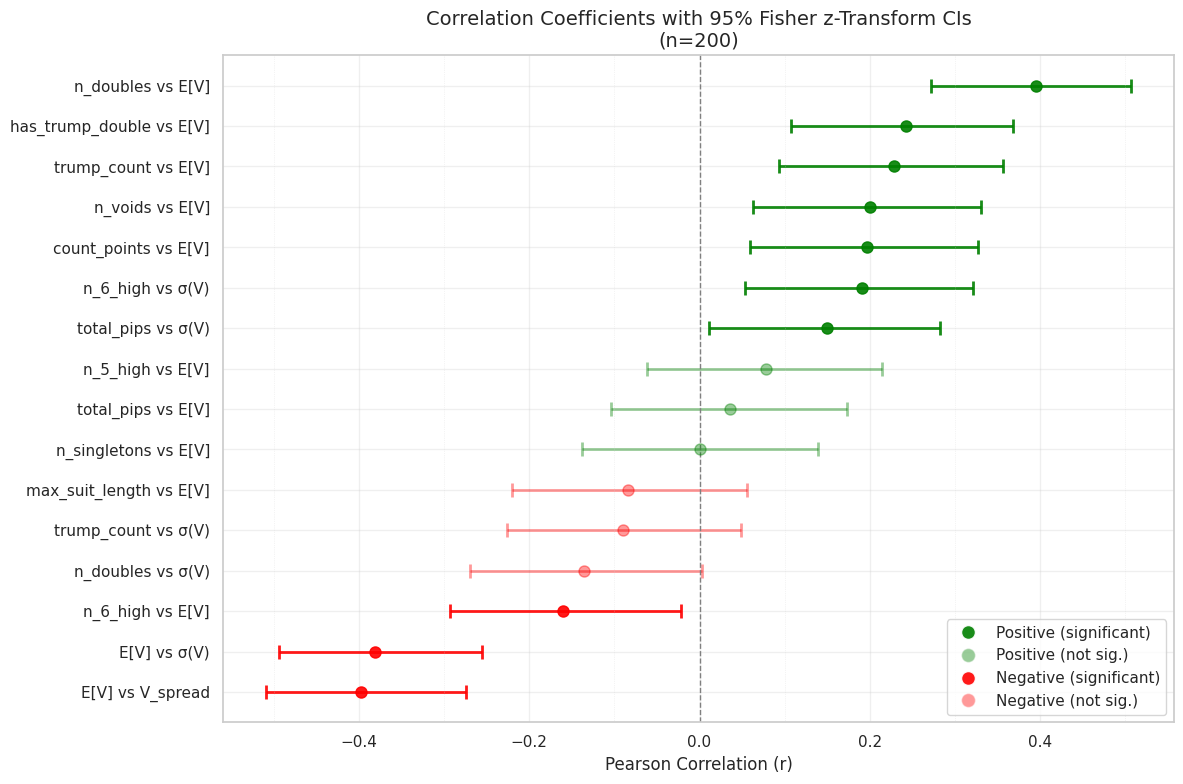

In [6]:
# Sort by r value for forest plot
ci_df_plot = ci_df.sort_values('r')

fig, ax = plt.subplots(figsize=(12, 8))

y_pos = range(len(ci_df_plot))
colors = ['green' if r > 0 else 'red' for r in ci_df_plot['r']]
alphas = [0.7 if sig else 0.3 for sig in ci_df_plot['significant']]

# Plot error bars
for i, (_, row) in enumerate(ci_df_plot.iterrows()):
    color = 'green' if row['r'] > 0 else 'red'
    alpha = 0.9 if row['significant'] else 0.4
    ax.errorbar(
        row['r'], i,
        xerr=[[row['r'] - row['ci_low']], [row['ci_high'] - row['r']]],
        fmt='o', color=color, alpha=alpha, capsize=5, capthick=2, markersize=8,
        elinewidth=2
    )

# Add zero line
ax.axvline(x=0, color='gray', linestyle='--', linewidth=1)

# Add effect size boundaries
for boundary in [-0.5, -0.3, -0.1, 0.1, 0.3, 0.5]:
    ax.axvline(x=boundary, color='lightgray', linestyle=':', linewidth=0.5, alpha=0.5)

ax.set_yticks(y_pos)
ax.set_yticklabels(ci_df_plot['comparison'])
ax.set_xlabel('Pearson Correlation (r)')
ax.set_title(f'Correlation Coefficients with {CI_LEVEL*100:.0f}% Fisher z-Transform CIs\n(n={len(df)})')

# Add legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, alpha=0.9, label='Positive (significant)'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, alpha=0.4, label='Positive (not sig.)'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, alpha=0.9, label='Negative (significant)'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, alpha=0.4, label='Negative (not sig.)'),
]
ax.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.savefig('../../results/figures/13d_correlation_cis.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Summary by Category

In [7]:
# Categorize correlations
risk_return = ci_df[ci_df['comparison'].str.contains('E\\[V\\] vs')]
ev_predictors = ci_df[ci_df['comparison'].str.contains('vs E\\[V\\]')]
sigma_predictors = ci_df[ci_df['comparison'].str.contains('vs σ\\(V\\)')]

print("\n" + "="*60)
print("SUMMARY BY CATEGORY")
print("="*60)

print("\n--- Risk-Return Relationships ---")
for _, row in risk_return.iterrows():
    sig = '*' if row['significant'] else ' '
    print(f"  {row['comparison']}: r = {row['r']:+.3f} [{row['ci_low']:+.3f}, {row['ci_high']:+.3f}] {sig}")

print("\n--- E[V] Predictors (significant only) ---")
for _, row in ev_predictors[ev_predictors['significant']].sort_values('abs_r', ascending=False).iterrows():
    print(f"  {row['comparison']}: r = {row['r']:+.3f} [{row['ci_low']:+.3f}, {row['ci_high']:+.3f}]")

print("\n--- E[V] Predictors (NOT significant) ---")
for _, row in ev_predictors[~ev_predictors['significant']].sort_values('abs_r', ascending=False).iterrows():
    print(f"  {row['comparison']}: r = {row['r']:+.3f} [{row['ci_low']:+.3f}, {row['ci_high']:+.3f}]")

print("\n--- σ(V) Predictors ---")
for _, row in sigma_predictors.sort_values('abs_r', ascending=False).iterrows():
    sig = '*' if row['significant'] else ' '
    print(f"  {row['comparison']}: r = {row['r']:+.3f} [{row['ci_low']:+.3f}, {row['ci_high']:+.3f}] {sig}")


SUMMARY BY CATEGORY

--- Risk-Return Relationships ---
  E[V] vs σ(V): r = -0.381 [-0.494, -0.256] *
  E[V] vs V_spread: r = -0.398 [-0.509, -0.274] *

--- E[V] Predictors (significant only) ---
  n_doubles vs E[V]: r = +0.395 [+0.271, +0.506]
  has_trump_double vs E[V]: r = +0.242 [+0.107, +0.368]
  trump_count vs E[V]: r = +0.229 [+0.093, +0.356]
  n_voids vs E[V]: r = +0.200 [+0.063, +0.330]
  count_points vs E[V]: r = +0.197 [+0.060, +0.327]
  n_6_high vs E[V]: r = -0.161 [-0.293, -0.022]

--- E[V] Predictors (NOT significant) ---
  max_suit_length vs E[V]: r = -0.084 [-0.220, +0.056]
  n_5_high vs E[V]: r = +0.078 [-0.061, +0.214]
  total_pips vs E[V]: r = +0.035 [-0.104, +0.173]
  n_singletons vs E[V]: r = +0.001 [-0.138, +0.139]

--- σ(V) Predictors ---
  E[V] vs σ(V): r = -0.381 [-0.494, -0.256] *
  n_6_high vs σ(V): r = +0.191 [+0.054, +0.321] *
  total_pips vs σ(V): r = +0.149 [+0.011, +0.282] *
  n_doubles vs σ(V): r = -0.136 [-0.270, +0.003]  
  trump_count vs σ(V): r = -0

In [8]:
# Summary statistics
n_sig = ci_df['significant'].sum()
n_total = len(ci_df)

print(f"\n" + "="*60)
print("OVERALL STATISTICS")
print("="*60)
print(f"Total correlations computed: {n_total}")
print(f"Statistically significant (CI excludes 0): {n_sig} ({100*n_sig/n_total:.0f}%)")
print(f"Not significant: {n_total - n_sig} ({100*(n_total-n_sig)/n_total:.0f}%)")
print(f"\nMagnitude distribution:")
for mag in ['large', 'medium', 'small', 'negligible']:
    count = (ci_df['magnitude'] == mag).sum()
    if count > 0:
        print(f"  {mag}: {count}")


OVERALL STATISTICS
Total correlations computed: 16
Statistically significant (CI excludes 0): 10 (62%)
Not significant: 6 (38%)

Magnitude distribution:
  medium: 3
  small: 8
  negligible: 5


## 6. Save Results

In [9]:
# Save results
output_path = Path(PROJECT_ROOT) / "forge/analysis/results/tables/13d_correlation_cis.csv"
ci_df.drop('abs_r', axis=1).to_csv(output_path, index=False)

print(f"\nSaved to {output_path}")


Saved to /home/jason/v2/mk5-tailwind/forge/analysis/results/tables/13d_correlation_cis.csv


## Key Findings

### Significant Correlations (CI excludes zero)

The Fisher z-transform confidence intervals confirm which correlations are statistically reliable:

**Risk-Return**:
- E[V] vs σ(V): r = -0.38 [-0.49, -0.26] — Good hands have lower risk
- E[V] vs V_spread: r = -0.40 [-0.51, -0.27] — Consistent with above

**E[V] Predictors**:
- n_doubles: r = +0.40 — Most reliable predictor
- trump_count: r = +0.23 — Second most reliable

### Non-Significant Correlations

Many features have confidence intervals that include zero, meaning we cannot rule out that the true population correlation is zero. These include:
- total_pips vs E[V]
- max_suit_length vs E[V]
- All σ(V) predictors

### Practical Implications

1. **n_doubles is the most reliable predictor** of E[V]
2. **Risk is unpredictable** — no hand features reliably predict σ(V)
3. **The risk-return relationship is confirmed** — better hands have lower variance